In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# raw_communities = pd.read_csv('../Data/communities.csv')
raw_egm = pd.read_csv("../Data/EGM.csv")
# raw_houses = pd.read_csv("../Data/Houses-by-suburb.csv")
raw_all_offences = pd.read_excel("../Data/LGA_Offences.xlsx", sheet_name=None)
raw_offense = raw_all_offences['Table 01']

KeyboardInterrupt: 

In [4]:
from bs4 import BeautifulSoup
import requests

url = "https://www.vec.vic.gov.au/electoral-boundaries/local-councils"
doc = requests.get(url).text

In [5]:
soup = BeautifulSoup(doc, 'html.parser')
base = soup.find('h3', string='A')

def clean_lga(lga: str):
    lga = lga.strip().lower()
    lga = lga.replace('-', ' ')

    replaces = {
        'moreland': 'merribek'
    }
    lga = ''.join([replaces.get(word, word) for word in lga.split() if word not in ['of', 'city', 'rural', 'shire', 'borough']])

    return lga

lgas = []
for link in base.find_all_next('a'):
    text = link.text.strip()
    if text == '':
        continue
    
    lgas.append(clean_lga(' '.join(text.split(' ')[:-1]).lower()))
    if text == 'Yarriambiack Shire Council':
        break

lgas = np.unique(lgas)

@np.vectorize
def islga(name):
    for t in lgas:
        if name in t:
            return True
        
    return False

lgas[:5]

array(['alpine', 'ararat', 'ballarat', 'banyule', 'basscoast'],
      dtype='<U19')

In [11]:
import re

# clean egm
def clean_egm(egm):
    print("CLEANING EGM")
    egm = egm.copy()
    egm = egm.iloc[:57, :]

    egm['LGA'] = egm['LGA Name'].apply(clean_lga)
    egm = egm.drop(['LGA Name'], axis=1)


    # filter only the ones in lgas
    old = pd.unique(egm['LGA'])
    egm = egm.query('@islga(LGA)')
    n = pd.unique(egm['LGA'])

    print(f"removed {np.setdiff1d(old, n)}")
    print(f"{n.size} LGAs")

    display(egm.head())

    return egm


def clean_offenses(crime):
    print('CLEANING OFFENSES')
    crime = crime.copy()
    crime = crime[crime['Local Government Area'] != 'Total']
    crime['LGA'] = crime['Local Government Area'].apply(lambda s: clean_lga(s.lower().strip()))
    crime = crime.drop(['Local Government Area'], axis=1)

    # filter only the ones in lgas
    old = pd.unique(crime['LGA'])
    crime = crime.query('@islga(LGA)')
    n = pd.unique(crime['LGA'])

    print(f"removed {np.setdiff1d(old, n)}")
    print(f"{n.size} LGAs")
    display(crime.head())
    return crime

def clean_community(community):
    print('CLEANING COMMUNITY')
    community: pd.DataFrame = community.copy()

    community['LGA'] = community['LGA'].apply(lambda s: "none" if (out := re.search(r"(.*) \(\w+\)", s.strip())) is None else out.group(1))
    community = community[community['LGA'] != "none"]
    community['LGA'] = community['LGA'].apply(clean_lga)

    # aggregate over numeric and categorical
    numerics = set(community.select_dtypes([np.number]).columns)
    categorical = set(community.columns) - numerics
    cat = {
        col: pd.Series.mode for col in categorical if col != 'LGA'
    }
    num = {
        col: pd.Series.sum for col in numerics
    }

    # fix percentages
    numper = [
        col for col in numerics if '%' in col or 'weighted' in col
    ]

    # create population and scale
    population = community['Population Density'] * community['Area (km^2)']
    community['Population'] = population
    community[numper] = community[numper].multiply(population, axis='index')

    # aggergate
    community = community.groupby("LGA").agg({**cat, **num, 'Population': pd.Series.sum})
    
    # rescale population
    community['Population Density'] = community['Population'] / community['Area (km^2)']
    community[numper] = community[numper].divide(community['Population'], axis='index')

    display(community.head(2))
    print(f"unique LGAs {community.shape[0]}")
    return community


def clear_region(region):
    region = region.strip().lower()

    try:
        if '(' in region and ')' in region:
            region = re.search(r"(.*) \([\w\s]+\)", region).group(1)
    except Exception as e:
        print(region)
        raise e
    
    return region

def clean_houses(communities, houses):
    print('CLEANING HOUSES')
    community = communities.copy()

    community['Locality'] = community['Community Name'].apply(clear_region)
    houses['Locality'] = houses['Locality'].apply(clear_region)
    houses = houses.set_index('Locality')

    # clear na and - drops, impute data
    houses = houses.dropna()
    houses = houses[~houses.isin(['-']).any(axis=1)]
    houses = houses.apply(pd.to_numeric)

    houses.rename(columns=lambda c: c + ' weighted', inplace=True)

    print(f'Rows before {community.shape[0]}')

    # join houses into community, TODO: this might repeat them?
    community = community.join(houses, on='Locality', how='inner')

    print(f'Rows after {community.shape[0]}')
    display(community.head(2))

    return community


print(f'total LGAs {len(lgas)}')
offense = clean_offenses(raw_offense)
egm = clean_egm(raw_egm)


total LGAs 79
CLEANING OFFENSES
removed ['justiceinstitutionsandimmigrationfacilities' 'unincorporatedvic']
79 LGAs


,Year,Year ending,Police Region,Offence Count,"Rate per 100,000 population",LGA
0,2023,December,1 North West Metro,8072,6256.318199,banyule
1,2023,December,1 North West Metro,17044,8666.589574,brimbank
2,2023,December,1 North West Metro,13715,8823.868581,darebin
3,2023,December,1 North West Metro,5720,6143.155350,hobsonsbay
4,2023,December,1 North West Metro,18342,7030.782116,hume


CLEANING EGM
removed []
57 LGAs


,Region,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,LGA
0,M,1.095429e+08,1.115836e+08,1.010001e+08,1.035006e+08,1.091612e+08,1.116516e+08,1.152932e+08,1.184756e+08,1.207063e+08,91066518.95,whittlesea
1,C,1.071793e+07,1.121941e+07,1.014142e+07,1.035065e+07,1.003788e+07,9.050693e+06,9.105582e+06,9.720508e+06,9.200584e+06,7004272.36,northerngrampians
2,C,1.184686e+08,1.183161e+08,1.097196e+08,1.116281e+08,1.130210e+08,1.132050e+08,1.154188e+08,1.188324e+08,1.203854e+08,89137264.73,greatergeelong
3,C,1.105642e+07,1.091608e+07,1.019461e+07,1.007489e+07,1.026330e+07,1.016289e+07,1.023095e+07,1.024279e+07,1.075162e+07,8316806.76,colacotway
4,C,1.083741e+07,1.116534e+07,1.054645e+07,1.030988e+07,1.057564e+07,1.061337e+07,1.139579e+07,1.196206e+07,1.234074e+07,9631820.68,moorabool


In [27]:
raw_community = pd.read_csv('./cleanedCommunities.csv')
raw_housing = pd.read_csv('./cleanedHousing.csv')

In [29]:
from IPython.display import display

# unpivot housing and egm
housing = pd.melt(raw_housing, id_vars=['LGA'], value_vars=[str(year) for year in range(2013,2023+1)], value_name='Median House Price', var_name='Year')
display(housing.head())

cleaned_egm = pd.melt(egm, id_vars=['LGA'], value_vars=[str(year) for year in range(2011, 2020+1)], value_name='EGM', var_name='Year')
display(cleaned_egm.head())

,LGA,Year,Median House Price
0,alpine,2013,253642.857143
1,ballarat,2013,552466.572467
2,banyule,2013,653361.591387
3,basscoast,2013,320354.166667
4,bawbaw,2013,384649.880211


,LGA,Year,EGM
0,whittlesea,2011,1.095429e+08
1,northerngrampians,2011,1.071793e+07
2,greatergeelong,2011,1.184686e+08
3,colacotway,2011,1.105642e+07
4,moorabool,2011,1.083741e+07


In [38]:
import sqlite3

def to_db(df: pd.DataFrame, name):
    cnx = sqlite3.connect('./data.sqlite3')
    df.to_sql(name=name, con=cnx, if_exists='replace')
    cnx.close()


to_db(offense, 'offense')
to_db(cleaned_egm, 'egm')
to_db(raw_community, 'community')
to_db(housing, 'housing')

# run sql

with sqlite3.connect('./data.sqlite3') as cnx:
    sql = """
select
    egm.LGA as "LGA", egm.Year, egm.EGM,
    housing."Median House Price",
    offense."Offence Count", offense."Rate per 100,000 population",
    community.*
from egm
inner join offense on egm.LGA = offense.LGA and offense.Year = egm.Year
inner join community on community.LGA = egm.LGA
inner join housing on housing.LGA = egm.LGA and housing.Year = egm.Year;
"""
    tables = pd.read_sql_query(sql, cnx)
    display(tables.head())
    tables = tables.drop(columns=['index']).copy()
    tables = tables.loc[:, ~tables.columns.duplicated()].copy()
    display(tables.head())

tables.to_csv('final.csv')
print(len(tables['LGA'].unique()), 'unique LGAs')

,LGA,Year,EGM,Median House Price,Offence Count,"Rate per 100,000 population",index,LGA,Travel time to GPO (minutes),Area (km^2),...,Time to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Travel time to nearest public hospital with emergency department,Presentations to emergency departments due to injury,Category 4 & 5 emergency department presentations,Number of Dwellings,Population,Location_x,Location_y,ABS remoteness category
0,whittlesea,2014,1.035006e+08,356757.028532,13591,7233.141209,73,whittlesea,34.862554,590.075860,...,12.687452,0.296999,12.687452,0.194756,0.478540,53907.0,166996.0,16.070609,18.525154,0
1,northerngrampians,2014,1.035065e+07,158750.000000,936,7947.694659,57,northerngrampians,179.410340,6720.196354,...,34.816253,0.081619,74.341947,0.279505,0.505500,7094.0,13042.0,-179.798887,102.227446,2
2,greatergeelong,2014,1.116281e+08,408437.396667,18509,8127.107630,26,greatergeelong,61.820207,1389.430557,...,12.133631,0.249244,12.133631,0.234432,0.574458,107828.0,249716.0,-49.407904,-36.376751,0
3,colacotway,2014,1.007489e+07,368416.666667,1534,7259.476598,15,colacotway,137.416278,3232.099823,...,40.806068,0.050232,89.621197,0.322547,0.533213,11821.0,21429.0,-114.485347,-75.055345,1
4,moorabool,2014,1.030988e+07,339500.000000,1921,6183.609090,51,moorabool,58.368445,2142.863230,...,18.455817,0.263974,33.194080,0.291807,0.612157,18640.0,47165.0,-63.629211,23.520312,1


,LGA,Year,EGM,Median House Price,Offence Count,"Rate per 100,000 population",Travel time to GPO (minutes),Area (km^2),ARIA+ (min),ARIA+ (max),...,Time to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Travel time to nearest public hospital with emergency department,Presentations to emergency departments due to injury,Category 4 & 5 emergency department presentations,Number of Dwellings,Population,Location_x,Location_y,ABS remoteness category
0,whittlesea,2014,1.035006e+08,356757.028532,13591,7233.141209,34.862554,590.075860,0.007974,0.056596,...,12.687452,0.296999,12.687452,0.194756,0.478540,53907.0,166996.0,16.070609,18.525154,0
1,northerngrampians,2014,1.035065e+07,158750.000000,936,7947.694659,179.410340,6720.196354,2.135649,2.837918,...,34.816253,0.081619,74.341947,0.279505,0.505500,7094.0,13042.0,-179.798887,102.227446,2
2,greatergeelong,2014,1.116281e+08,408437.396667,18509,8127.107630,61.820207,1389.430557,0.152898,0.224843,...,12.133631,0.249244,12.133631,0.234432,0.574458,107828.0,249716.0,-49.407904,-36.376751,0
3,colacotway,2014,1.007489e+07,368416.666667,1534,7259.476598,137.416278,3232.099823,1.273625,1.806754,...,40.806068,0.050232,89.621197,0.322547,0.533213,11821.0,21429.0,-114.485347,-75.055345,1
4,moorabool,2014,1.030988e+07,339500.000000,1921,6183.609090,58.368445,2142.863230,0.331739,0.880712,...,18.455817,0.263974,33.194080,0.291807,0.612157,18640.0,47165.0,-63.629211,23.520312,1


56 unique LGAs


In [4]:
df = pd.read_csv('./final.csv', index_col=0)
df.head()

,LGA,Year,EGM,Median House Price,Offence Count,"Rate per 100,000 population",Travel time to GPO (minutes),Area (km^2),ARIA+ (min),ARIA+ (max),...,Time to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Travel time to nearest public hospital with emergency department,Presentations to emergency departments due to injury,Category 4 & 5 emergency department presentations,Number of Dwellings,Population,Location_x,Location_y,ABS remoteness category
0,whittlesea,2014,1.035006e+08,356757.028532,13591,7233.141209,34.862554,590.075860,0.007974,0.056596,...,12.687452,0.296999,12.687452,0.194756,0.478540,53907.0,166996.0,16.070609,18.525154,0
1,northerngrampians,2014,1.035065e+07,158750.000000,936,7947.694659,179.410340,6720.196354,2.135649,2.837918,...,34.816253,0.081619,74.341947,0.279505,0.505500,7094.0,13042.0,-179.798887,102.227446,2
2,greatergeelong,2014,1.116281e+08,408437.396667,18509,8127.107630,61.820207,1389.430557,0.152898,0.224843,...,12.133631,0.249244,12.133631,0.234432,0.574458,107828.0,249716.0,-49.407904,-36.376751,0
3,colacotway,2014,1.007489e+07,368416.666667,1534,7259.476598,137.416278,3232.099823,1.273625,1.806754,...,40.806068,0.050232,89.621197,0.322547,0.533213,11821.0,21429.0,-114.485347,-75.055345,1
4,moorabool,2014,1.030988e+07,339500.000000,1921,6183.609090,58.368445,2142.863230,0.331739,0.880712,...,18.455817,0.263974,33.194080,0.291807,0.612157,18640.0,47165.0,-63.629211,23.520312,1


In [59]:
plt.rcdefaults()

In [5]:
df['crime'] = df['Rate per 100,000 population']

,Median House Price
Year,
2014,486444.450657
2015,539156.978042
2016,632494.254823
2017,722900.402703
2018,719526.264719
2019,712070.907458
2020,744250.000000


             LGA  Median House Price
388  stonnington        2.841161e+06
366   boroondara        2.034634e+06


,EGM
Year,
2014,6.483376e+07
2015,6.667817e+07
2016,6.789244e+07
2017,6.766602e+07
2018,6.992443e+07
2019,6.996817e+07
2020,5.138109e+07


          LGA           EGM
381  brimbank  1.019742e+08
377     casey  9.800078e+07


,crime
Year,
2014,7854.022241
2015,8360.999023
2016,8956.655058
2017,7977.004925
2018,7943.150642
2019,8200.238171
2020,8272.523822


           LGA         crime
363  melbourne  21397.628218
356    latrobe  17764.684412
386      yarra  14692.433428


''

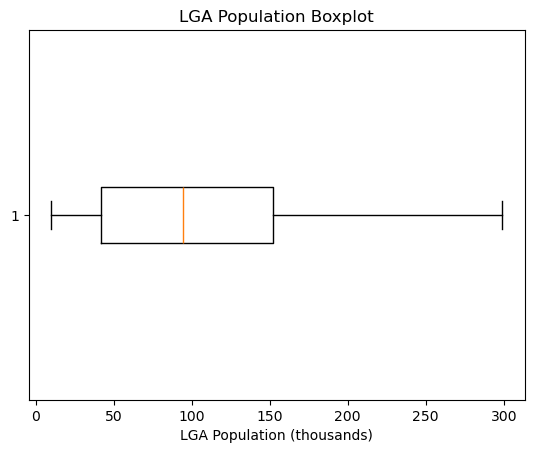

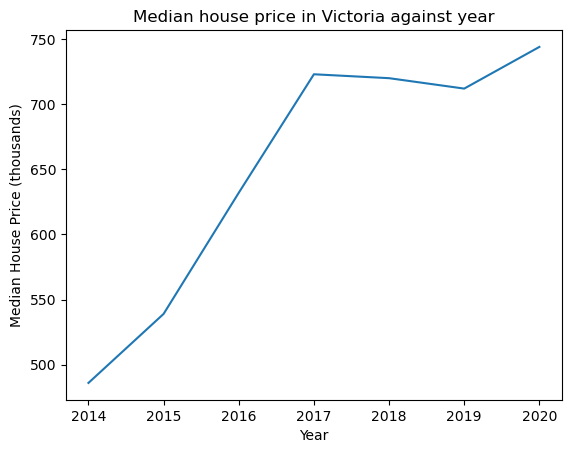

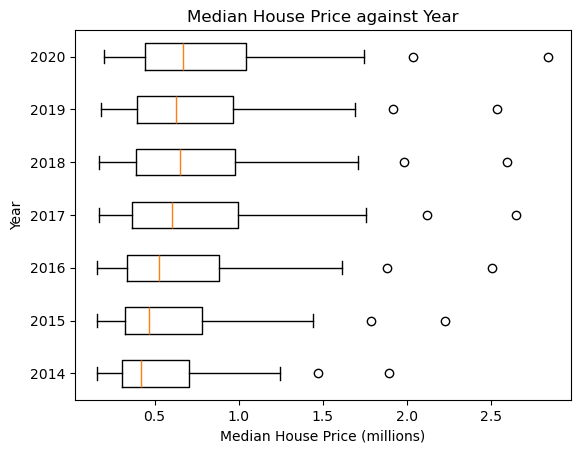

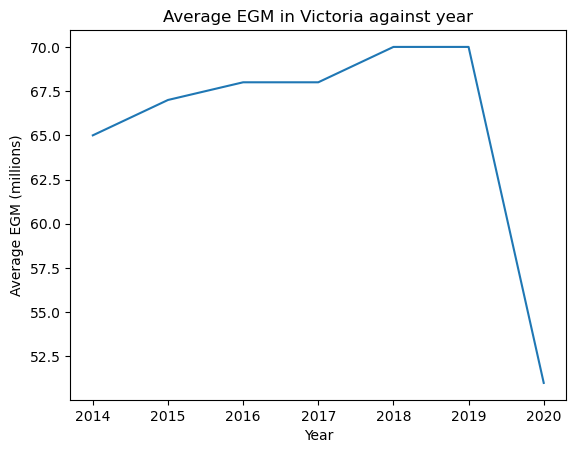

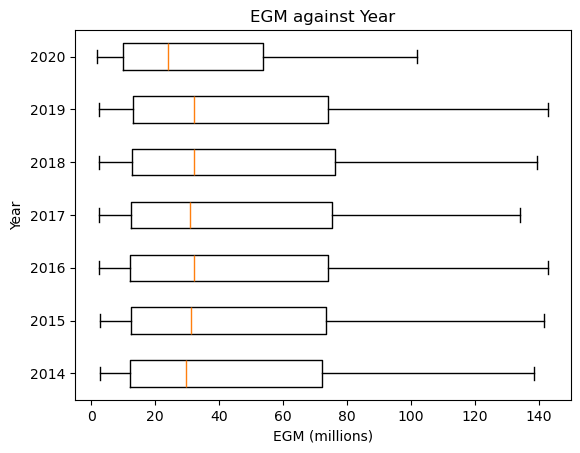

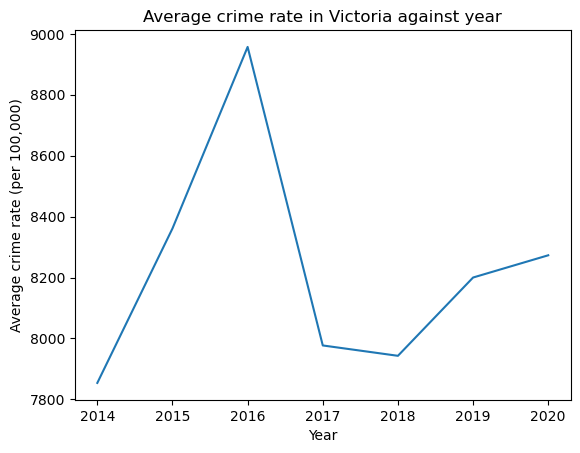

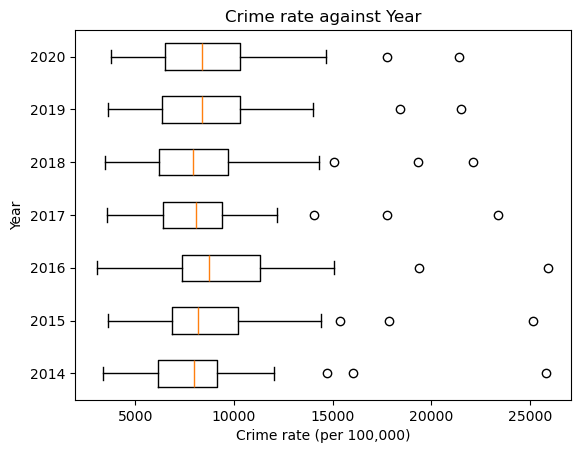

In [10]:
import matplotlib.pyplot as plt

def weighted_median(values, weights):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, 0.5 * c[-1])]]

# get population histogram
def plot_population():
    out = df.drop(columns=['Year']).drop_duplicates(subset=['LGA'], keep='first')
    plt.figure()
    plt.boxplot(out['Population'] / 1000, vert=False)
    plt.title('LGA Population Boxplot')
    plt.xlabel("LGA Population (thousands)")
    
def plot_housing():
    # average housing price every year
    raw = df.drop(columns=['Year']).drop_duplicates(subset=['LGA'], keep='first')
    weighting = raw['Population'] / raw['Population'].sum()
    out = df.groupby('Year').agg({
        "Median House Price": lambda p: weighted_median(p.values, weighting.values)
    })
    display(out)
    plt.figure()
    plt.title('Median house price in Victoria against year')
    plt.xlabel('Year')
    plt.ylabel('Median House Price (thousands)')
    plt.plot(np.round(out / 1000))

def plot_housing_year():
    years = {}
    for year in df['Year'].unique():
        prices = df[df['Year'] == year]
        years[year] = prices['Median House Price'].values / 1e6

    print(prices.nlargest(2, ['Median House Price'])[['LGA', 'Median House Price']])

    fig, ax = plt.subplots()
    ax.boxplot(years.values(), vert=False)
    ax.set_yticklabels(years.keys())
    ax.set_ylabel("Year")
    ax.set_xlabel("Median House Price (millions)")
    ax.set_title('Median House Price against Year')


def plot_egm():
    raw = df.drop(columns=['Year']).drop_duplicates(subset=['LGA'], keep='first')
    weighting = raw['Population'] / raw['Population'].sum()
    out = df.groupby('Year').agg({
        "EGM": lambda p: np.sum(p.values * weighting.values)
    })
    display(out)
    plt.figure()
    plt.title('Average EGM in Victoria against year')
    plt.xlabel('Year')
    plt.ylabel('Average EGM (millions)')
    plt.plot(np.round(out / 1e6))


def plot_egm_year():
    years = {}
    for year in df['Year'].unique():
        prices = df[df['Year'] == year]
        years[year] = prices['EGM'].values / 1e6

    print(prices.nlargest(2, ['EGM'])[['LGA', 'EGM']])

    fig, ax = plt.subplots()
    ax.boxplot(years.values(), vert=False)
    ax.set_yticklabels(years.keys())
    ax.set_ylabel("Year")
    ax.set_xlabel("EGM (millions)")
    ax.set_title('EGM against Year')


def plot_crime():
    raw = df.drop(columns=['Year']).drop_duplicates(subset=['LGA'], keep='first')
    weighting = raw['Population'] / raw['Population'].sum()
    out = df.groupby('Year').agg({
        "crime": lambda p: np.sum(p.values * weighting.values)
    })
    display(out)
    plt.figure()
    plt.title('Average crime rate in Victoria against year')
    plt.xlabel('Year')
    plt.ylabel('Average crime rate (per 100,000)')
    plt.plot(np.round(out))


def plot_crime_year():
    years = {}
    for year in df['Year'].unique():
        prices = df[df['Year'] == year]
        years[year] = prices['crime'].values

    print(prices.nlargest(3, ['crime'])[['LGA', 'crime']])

    fig, ax = plt.subplots()
    ax.boxplot(years.values(), vert=False)
    ax.set_yticklabels(years.keys())
    ax.set_ylabel("Year")
    ax.set_xlabel("Crime rate (per 100,000)")
    ax.set_title('Crime rate against Year')


plot_population()
plot_housing()
plot_housing_year()
plot_egm()
plot_egm_year()
plot_crime()
plot_crime_year()
;

Index(['Child Protection and Family', 'Dental', 'General Practice',
       'Homelessness', 'Mental Health', 'Public Housing Dwellings',
       'Dwellings with no motor vehicle', 'Unemployed, persons', 'crime'],
      dtype='object')


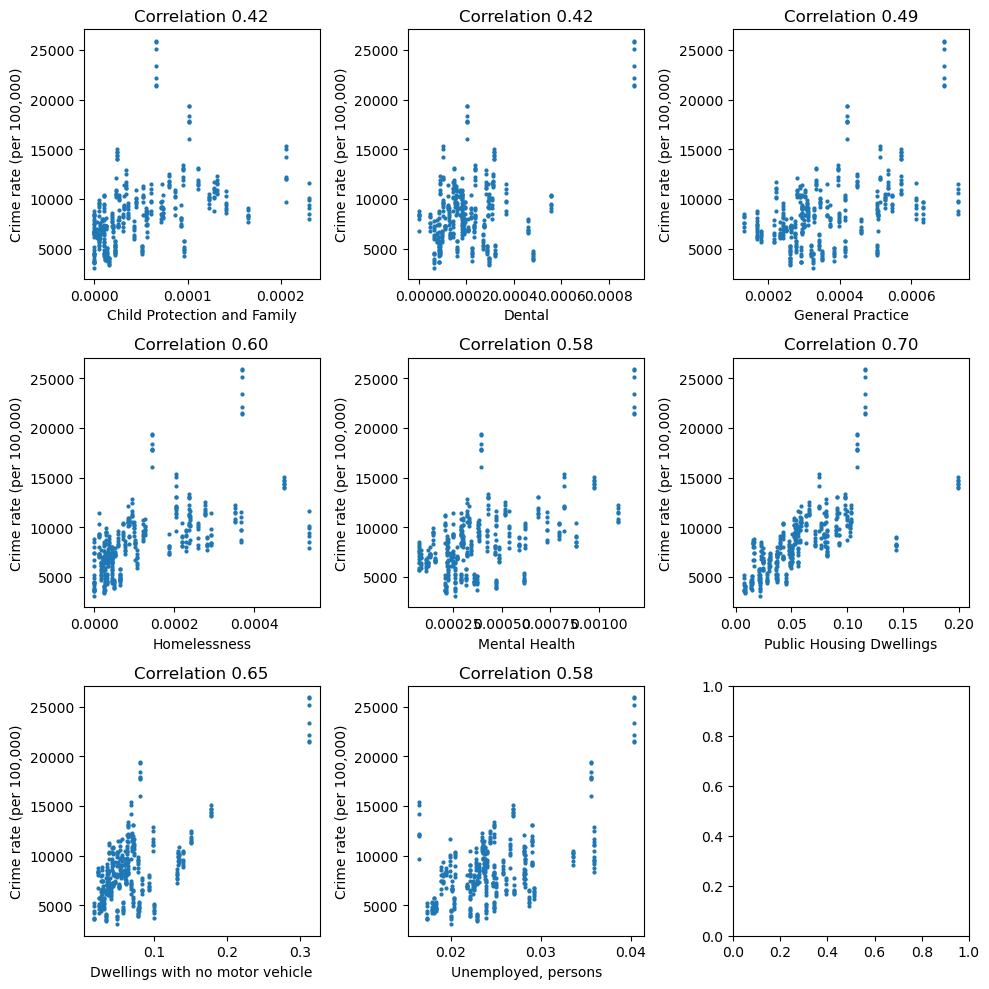

In [84]:
from sklearn.preprocessing import StandardScaler

def correlation_analysis():
    num = df.select_dtypes(include=[np.number])
    num = num.drop(columns=['Rate per 100,000 population', 'Offence Count']).copy()
    corr = num.corr()
    highest = corr[corr['crime'] > 0.4].index
    print(highest)
    filtered = num[highest].copy()

    # scaler = StandardScaler()
    # filtered[filtered.columns] = scaler.fit_transform(filtered[filtered.columns])

    plots = len(filtered.columns)
    fig, ax = plt.subplots(3, (plots+1)//3, figsize=(10, 10))
    axs = ax.ravel()
    for i, col in enumerate(filtered.columns):
        if col == 'crime':
            continue

        cor = filtered[col].corr(filtered['crime'])
        axs[i].scatter(filtered[col], filtered['crime'], s=4)
        axs[i].set_xlabel(f"{col}")
        axs[i].set_ylabel('Crime rate (per 100,000)')
        axs[i].set_title(f"Correlation {cor:.2f}")

    fig.tight_layout()


correlation_analysis()

In [ ]:
def MI_analysis():
    pass